Lets apply a neural network to a dataset found from Kaggle:

https://www.kaggle.com/datasets/mohithsairamreddy/salary-data

To do this, we need to incorporate data handling strategies into the data first.

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
salary_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Job Salaries/Salary_Data.csv')

In [148]:
salary_data.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


We first need to convert the "Job Title" column into a useful one, which is a lot more challenging than simply using pd.get_dummies, as this approach has the potential to add as many columns to the dataset as there are data points.

In [149]:
title = salary_data.pop('Job Title')
title = title.fillna('')
title.head()

,Job Title
0,Software Engineer
1,Data Analyst
2,Senior Manager
3,Sales Associate
4,Director


Our strategy will involve using TF-IDF, which we use here.

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
title_comps = vectorizer.fit_transform(title)

featurenames = vectorizer.get_feature_names_out()
idfs = pd.DataFrame({'word': featurenames, 'idf': vectorizer.idf_})
idfs.head()
idfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   word    90 non-null     object 
 1   idf     90 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


We also create an IDF dataframe to identify columns/features that aren't particularly important. This could occur if a typo was present in one job in the dataset, or if a very unique job was included in the list (for example, "sand pirate" might be in the list, resulting in the addition of columns "sand" and "pirate"). We can counteract this by checking IDF values, which indicate the importance of a term in the dataset (so, the IDF for the term "sand" would be extremely high, since "sand" isn't a common word in job titles).

In [151]:
idf_filtered = idfs[idfs['idf'] > 9]
idf_filtered.head()

,word,idf
3,advertising,9.117462
6,architect,9.117462
9,assurance,9.117462
11,capital,9.117462
12,ceo,9.117462


Above is what is filtering jobs that have a relatively high IDF - not shown in the data frequently. Although the IDFs are high, they seem to still be quite common terms used in job titles. So, our dataset doesn't have any outliers or typos in it, so we decide not to remove any columns in our computation of TF-IDF.

In [152]:
titles = pd.DataFrame(title_comps.toarray(), columns=featurenames)

salary_data = pd.concat([salary_data, titles], axis=1)
salary_data

,Age,Gender,Education Level,Years of Experience,Salary,account,accountant,administrative,advertising,advisor,...,success,supply,support,technical,technology,training,ux,vp,web,writer
0,32.0,Male,Bachelor's,5.0,90000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28.0,Female,Master's,3.0,65000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,45.0,Male,PhD,15.0,150000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.0,Female,Bachelor's,7.0,60000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52.0,Male,Master's,20.0,200000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6699,49.0,Female,PhD,20.0,200000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6700,32.0,Male,High School,3.0,50000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6701,30.0,Female,Bachelor's Degree,4.0,55000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6702,46.0,Male,Master's Degree,14.0,140000.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
print(salary_data.isnull().sum())

Age                    2
Gender                 2
Education Level        3
Years of Experience    3
Salary                 5
                      ..
training               0
ux                     0
vp                     0
web                    0
writer                 0
Length: 95, dtype: int64


Given the size of our data (6700+ entries), losing 95 entries won't set us back that much, so let's just remove those entries with null data.

In [154]:
salary_data = salary_data.dropna()

Now let's do some EDA.

**Question: How can different specifics about an individual impact their salary?**

In [155]:
salary_data.groupby("Education Level")["Salary"].mean()

,Salary
Education Level,
Bachelor's,124767.658730
Bachelor's Degree,85174.886093
High School,36706.694196
Master's,157604.166667
Master's Degree,125075.333969
PhD,165684.828947
phD,120000.000000


We encountered a problem; our data isn't fixed just yet. We need to perform a mapping for these pairs that were named slightly differently.

In [156]:
education_mapping = {
    "Bachelor's": "Bachelor's",
    "Bachelor's Degree": "Bachelor's",
    "High School": "High School",
    "Master's": "Master's",
    "Master's Degree": "Master's",
    "PhD": "PhD",
    "phD": "PhD"
}

salary_data = salary_data.replace({"Education Level": education_mapping}) #Now maps all our inputs to 4 different places instead of 7

salary_data.groupby("Education Level")["Salary"].mean() # Now will group correctly

,Salary
Education Level,
Bachelor's,95082.908640
High School,36706.694196
Master's,130112.056452
PhD,165651.457999


In [157]:
salary_data.groupby("Gender")["Salary"].mean()

,Salary
Gender,
Female,107888.998672
Male,121395.697630
Other,125869.857143


We see that gender impacts salary in this data...

/tmp/ipython-input-733700575.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x = 'Education Level', y = 'Salary', data = salary_data, kind = 'bar', palette = 'cubehelix')


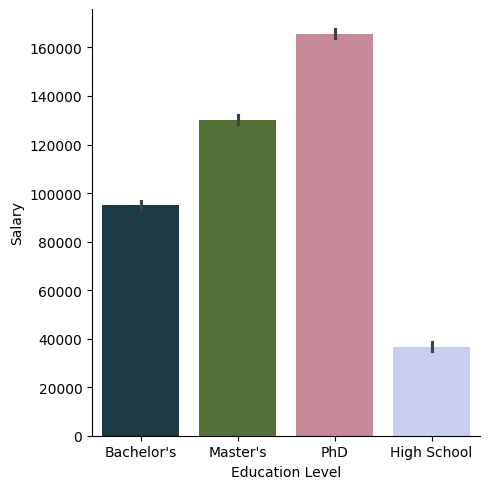

In [158]:
sns.catplot(x = 'Education Level', y = 'Salary', data = salary_data, kind = 'bar', palette = 'cubehelix')

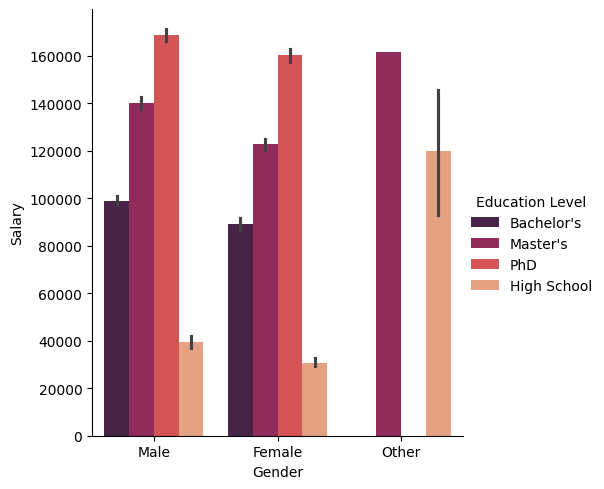

In [159]:
sns.catplot(x = 'Gender', y = 'Salary', data = salary_data, hue = 'Education Level', kind = 'bar', palette = 'rocket')

Here we can see that Gender decreases salary between Male and Female quite similarly across different Education Levels.

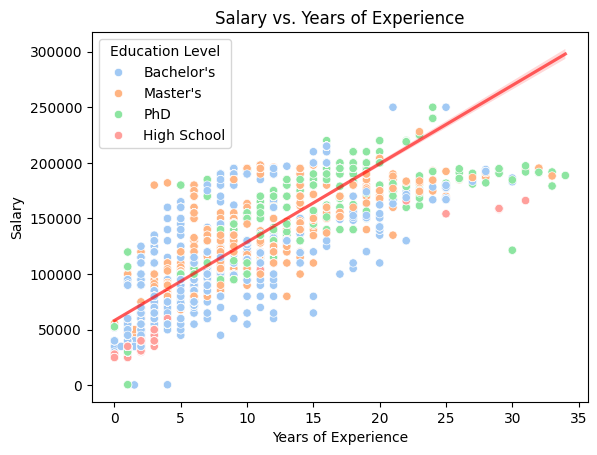

In [160]:
sns.scatterplot(x = 'Years of Experience', y='Salary', hue = 'Education Level', data=salary_data, palette='pastel')
sns.regplot(x='Years of Experience', y='Salary', data=salary_data, scatter=False, color = 'red', line_kws={'alpha': 0.6})
plt.title('Salary vs. Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

More experience = more money!

In [161]:
salary_data.columns = salary_data.columns.str.strip()
salary_data = pd.get_dummies(salary_data, columns=['Gender', 'Education Level'])

# NN will need numeric values for later, so convert things to 0, 1
for col in salary_data.columns:
    if salary_data[col].dtype == 'bool':
        salary_data[col] = salary_data[col].astype(int)

salary_data.head()

,Age,Years of Experience,Salary,account,accountant,administrative,advertising,advisor,analyst,architect,...,vp,web,writer,Gender_Female,Gender_Male,Gender_Other,Education Level_Bachelor's,Education Level_High School,Education Level_Master's,Education Level_PhD
0,32.0,5.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,1,0,0,0
1,28.0,3.0,65000.0,0.0,0.0,0.0,0.0,0.0,0.75487,0.0,...,0.0,0.0,0.0,1,0,0,0,0,1,0
2,45.0,15.0,150000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,1
3,36.0,7.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,1,0,0,1,0,0,0
4,52.0,20.0,200000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,0,0,1,0


Here we decide to use get_dummies for the other columns that aren't quantified, because there are only 3-4 possible values that each original column had, whereas job title could've had infinitely many.

We can get a big look at the data relationships by looking at the correlation matrix.

<Axes: >

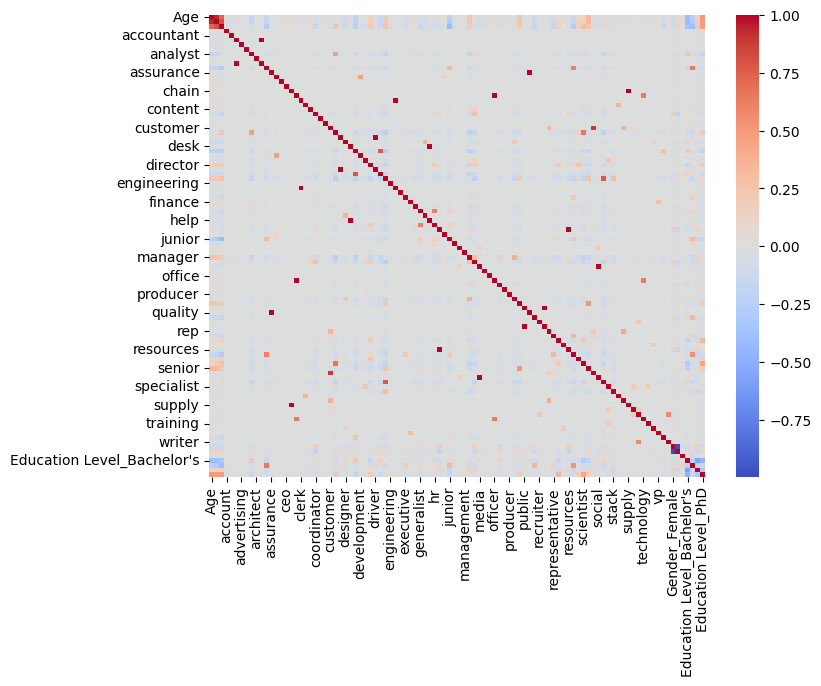

In [162]:
corr = salary_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt=".2f")

/tmp/ipython-input-1535298218.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_salary.index, y=corr_salary.values, palette=colors, ax=ax)
/tmp/ipython-input-1535298218.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=corr_salary.index, y=corr_salary.values, palette=colors, ax=ax)


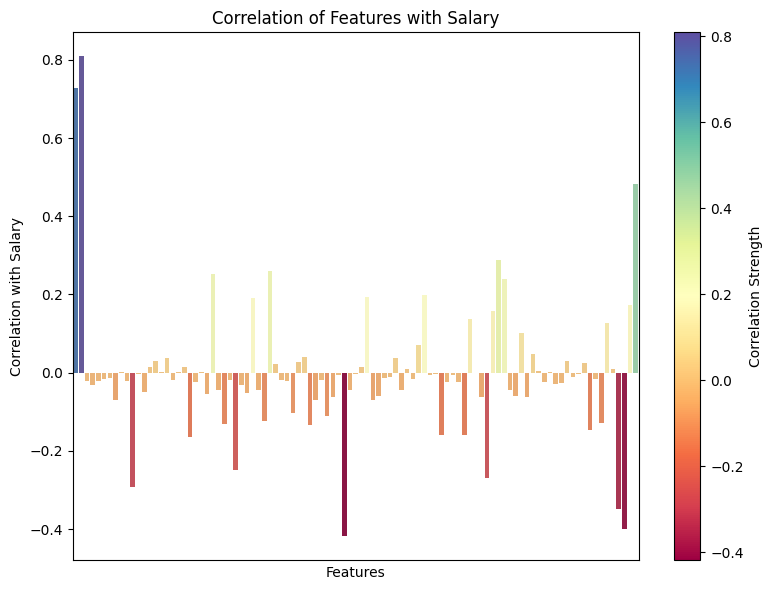

In [163]:
import matplotlib.cm as cm

corr_salary = corr['Salary'].drop('Salary')

norm = plt.Normalize(corr_salary.min(), corr_salary.max())
cmap = cm.Spectral
colors = cmap(norm(corr_salary.values))

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=corr_salary.index, y=corr_salary.values, palette=colors, ax=ax)

plt.xticks([])
plt.xlabel('Features')
plt.ylabel('Correlation with Salary')
plt.title('Correlation of Features with Salary')

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Correlation Strength')

plt.tight_layout()
plt.show()

We can now see how each column can impact salary. Let's look at the top 3 most highly correlated columns more directly.

In [164]:
salary_data.head()

,Age,Years of Experience,Salary,account,accountant,administrative,advertising,advisor,analyst,architect,...,vp,web,writer,Gender_Female,Gender_Male,Gender_Other,Education Level_Bachelor's,Education Level_High School,Education Level_Master's,Education Level_PhD
0,32.0,5.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,1,0,0,0
1,28.0,3.0,65000.0,0.0,0.0,0.0,0.0,0.0,0.75487,0.0,...,0.0,0.0,0.0,1,0,0,0,0,1,0
2,45.0,15.0,150000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,1
3,36.0,7.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,1,0,0,1,0,0,0
4,52.0,20.0,200000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,0,0,1,0


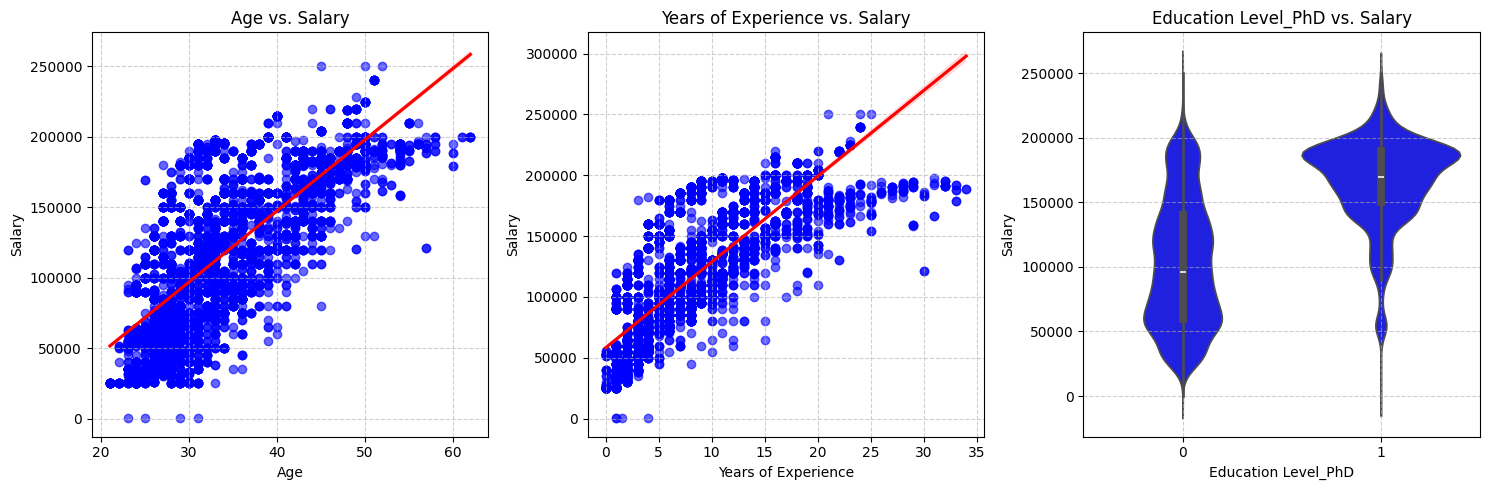

In [165]:
subset = salary_data[['Age', 'Years of Experience', 'Education Level_PhD']].copy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for feature, ax in zip(subset.columns, axes.flatten()):
    if feature == 'Education Level_PhD':
        sns.violinplot(x = subset[feature], y = salary_data['Salary'], ax = ax, color = 'blue')
    else:
        sns.regplot(x=subset[feature], y=salary_data['Salary'], ax=ax, color = 'blue', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    ax.set_xlabel(feature)
    ax.set_ylabel('Salary')
    ax.set_title(f"{feature} vs. Salary")

    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Now we have clean data with  doing some EDA, now we can apply a neural network to predict salary from our other components.

**Question : How will a NN perform on our dataset?**

In [166]:
salary_data.head()

,Age,Years of Experience,Salary,account,accountant,administrative,advertising,advisor,analyst,architect,...,vp,web,writer,Gender_Female,Gender_Male,Gender_Other,Education Level_Bachelor's,Education Level_High School,Education Level_Master's,Education Level_PhD
0,32.0,5.0,90000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,1,0,0,0
1,28.0,3.0,65000.0,0.0,0.0,0.0,0.0,0.0,0.75487,0.0,...,0.0,0.0,0.0,1,0,0,0,0,1,0
2,45.0,15.0,150000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,0,0,0,1
3,36.0,7.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,1,0,0,1,0,0,0
4,52.0,20.0,200000.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0,1,0,0,0,1,0


Epoch 1, Loss: 6120.6235
Epoch 2, Loss: 20172.2168
Epoch 3, Loss: 8637.5840
Epoch 4, Loss: 3495.7864
Epoch 5, Loss: 1026.2938
Epoch 6, Loss: 7091.0034
Epoch 7, Loss: 2790.0139
Epoch 8, Loss: 3935.0662
Epoch 9, Loss: 2730.9802
Epoch 10, Loss: 1718.8519
Epoch 11, Loss: 778.3032
Epoch 12, Loss: 595.9838
Epoch 13, Loss: 339.1024
Epoch 14, Loss: 968.1943
Epoch 15, Loss: 522.0912
Epoch 16, Loss: 1316.0001
Epoch 17, Loss: 972.8735
Epoch 18, Loss: 1125.1072
Epoch 19, Loss: 503.6136
Epoch 20, Loss: 607.1445
Epoch 21, Loss: 837.3569
Epoch 22, Loss: 531.0938
Epoch 23, Loss: 565.6274
Epoch 24, Loss: 155.6839
Epoch 25, Loss: 652.6461
Epoch 26, Loss: 722.7863
Epoch 27, Loss: 310.2848
Epoch 28, Loss: 332.1194
Epoch 29, Loss: 2308.5881
Epoch 30, Loss: 461.0855
Epoch 31, Loss: 232.3742
Epoch 32, Loss: 784.8846
Epoch 33, Loss: 996.2434
Epoch 34, Loss: 884.3406
Epoch 35, Loss: 692.8274
Epoch 36, Loss: 322.7219
Epoch 37, Loss: 165.4296
Epoch 38, Loss: 1202.7394
Epoch 39, Loss: 791.8770
Epoch 40, Loss: 482

/tmp/ipython-input-1961367482.py:77: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([lo, hi], [lo, hi], 'r-', linestyle='--', linewidth=2, c = 'red')
/tmp/ipython-input-1961367482.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([lo, hi], [lo, hi], 'r-', linestyle='--', linewidth=2, c = 'red')


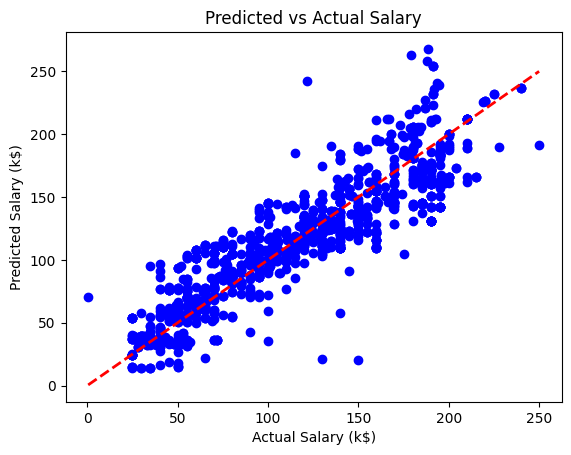

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

Y = salary_data['Salary'].astype(float)
X = salary_data.drop(columns=['Salary'], axis=1).copy()

# Convert boolean columns to integers
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)

y_train_k = (Y_train.values / 1000.0).astype(np.float32).reshape(-1, 1)
y_test_k  = (Y_test.values  / 1000.0).astype(np.float32).reshape(-1, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train_k, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test_k, dtype=torch.float32)

tens_data = TensorDataset(X_train_tensor, Y_train_tensor)

class NeuralNetwork(nn.Module):
  def __init__(self, in_dim):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(in_dim, 128)

    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return torch.relu(x)

model = NeuralNetwork(X_train_tensor.shape[1])

loader = DataLoader(tens_data, batch_size=24, shuffle=True)

mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 75
for epoch in range(epochs):
    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = mse_loss(predictions, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

with torch.no_grad():
  pred = model(X_test_tensor)


# --- 9) Plot Predicted vs Actual (both in thousands) ---
y_true = Y_test_tensor.numpy().ravel()
y_pred = pred.numpy().ravel()

plt.scatter(y_true, y_pred, color = 'blue')
plt.xlabel("Actual Salary (k$)")
plt.ylabel("Predicted Salary (k$)")
plt.title("Predicted vs Actual Salary")
lo, hi = y_true.min(), y_true.max()
plt.plot([lo, hi], [lo, hi], 'r-', linestyle='--', linewidth=2, c = 'red')
plt.show()

In [168]:
with torch.no_grad():
  pred = model(X_test_tensor)


y_true = Y_test_tensor.numpy().ravel()
y_pred = pred.numpy().ravel()

from sklearn.metrics import r2_score

r2 = r2_score(Y_test_tensor.numpy(), pred.numpy())
print(f"R^2 Score: {r2 * 100:.2f}% variance explained")


R^2 Score: 80.28% variance explained
